In [1]:
from tqdm import tqdm_notebook as tqdm
import sys
import scipy.interpolate as interpol
import scipy.ndimage.filters as fil
import scipy.ndimage.measurements as me
import scipy.ndimage as nd
import tifffile
import numpy as np
import pickle
import matplotlib.pyplot as plt

# SETTING FUNCTIONS

In [2]:
def rotate_matrix(angle, v):

    ux = v[0]
    uy = v[1]
    uz = v[2]
    cos = np.cos(angle)
    sin = np.sin(angle)
    cos_1 = 1-cos

    M = np.array([[cos+ux*ux*cos_1, ux*uy*cos_1-uz*sin, ux*uz*cos_1+uy*sin],
                  [uy*ux*cos_1+uz*sin, cos+uy*uy*cos_1, uy*uz*cos_1-ux*sin],
                  [uz*ux*cos_1-uy*sin, uz*uy*cos_1+ux*sin, cos+uz*uz*cos_1]])

    return M

In [3]:
def orthogonal_vectors(vector):
    '''Get versors that are orthogonal to vet'''
    if vector[0] != 0:
        b2 = 1.
        c2 = 0.  # 1.
        a2 = -vector[1]*b2/vector[0]

        e1 = np.array([a2, b2, c2])
        e2 = np.cross(vector, e1)
    else:
        a2 = 1.
        b2 = 0.
        c2 = 0.

        e1 = np.array([a2, b2, c2])
        e2 = np.cross(vector, e1)

    e1 = e1/np.sqrt(e1[0]**2+e1[1]**2+e1[2]**2)
    e2 = e2/np.sqrt(e2[0]**2+e2[1]**2+e2[2]**2)

    return e1, e2

In [4]:
def create_isoplane(dict_distance, dict_midline, dict_angle, image_mask):
    """Images for visualization proposes
    """

    image_iso_distance = (100*dict_distance).astype(np.uint8)
    max_dist = np.max(list(dict_distance.keys()))
    for i in range(20, max_dist):
        if (i-20) % 30 == 0:
            image_iso_distance[dict_distance[i]] = 255

    image_iso_mid = (100*image_mask).astype(np.uint8)
    max_mid = np.max(list(dict_midline.keys()))
    for i in range(1, max_mid):
        if i % 50 == 0:
            image_iso_mid[dict_midline[i]] == 255

    image_iso_angle = (100*image_mask).astype(np.uint8)
    max_angle = np.max(list(dict_angle.keys()))
    for i in range(1, max_angle):
        if i % 20 == 0:
            image_iso_angle[dict_angle[i]] == 255

    tifffile.imsave('image_iso_distance.tif', image_iso_distance)
    tifffile.imsave('image_iso_mid.tif', image_iso_mid)
    tifffile.imsave('image_iso_angle.tif', image_iso_angle)

In [5]:
def dist_to_plane(point, plane):
    """Finds distance to point to plane
    """

    p_plane = plane[0]
    v_plane = plane[1]

    dist = np.absolute([v_plane[1]*(point[1]-p_plane[1]) +
                        v_plane[2]*(point[2]-p_plane[2]) +
                        v_plane[0]*(point[0]-p_plane[0])
                        ])[0]/np.linalg.norm(v_plane)

    return dist


# LOADING FILES/SETTING CONSTANTS

In [6]:
PLANE_SIZE = 750

IMAGE_MASK = pickle.load(open('../data/masks/mask_full_beak.dat', 'rb'))
NODE_MASK = pickle.load(open('../data/masks/mask_nodes.dat', 'rb'))

SIZE_Z, SIZE_X, SIZE_Y = IMAGE_MASK.shape

# MAIN PROCESSING

## Creating Distance Dicts

In [7]:
image_distance = nd.distance_transform_cdt(IMAGE_MASK)
distance_dict = {}
already_added = []
for i in tqdm(range(image_distance.shape[0]), desc='Distance Dict'):
    for j in range(image_distance.shape[1]):
        for k in range(image_distance.shape[2]):

            d = image_distance[i, j, k]
            
            if d != 0:
                if d in distance_dict:
                    distance_dict[d].extend([(i, j, k)])
                else:
                    distance_dict[d] = [(i, j, k)]

                image_distance[i, j, k] = 0

## Creating Middle Line

In [8]:
center = np.zeros((IMAGE_MASK.shape[0], 3))
for i in tqdm(range(IMAGE_MASK.shape[0]), desc='Middle Line'):

    center[i, 0] = i
    C = nd.center_of_mass(IMAGE_MASK[i], IMAGE_MASK[i], 1)

    center[i, 1:] = C

z = center[:, 0]
x = center[:, 1]
y = center[:, 2]
w = np.ones(x.size)
w[0] = 1e4
w[-1] = 1e4

i_x = interpol.UnivariateSpline(z, x, w=w, k=3, s=1e5)
i_y = interpol.UnivariateSpline(z, y, w=w, k=3, s=1e5)

seg_smooth = np.zeros([z.size, 3])
seg_smooth[:, 0] = z
seg_smooth[:, 1] = i_x(z)
seg_smooth[:, 2] = i_y(z)

## Creating Planes and Angles

In [9]:
mat_plane = np.zeros(
    [len(seg_smooth)-1, PLANE_SIZE, PLANE_SIZE],
    dtype=np.uint8
)

mat_show = (100*IMAGE_MASK).astype(np.uint8)

midline_dict = {}
angle_dict = {}
plane_dict = {}


for j in tqdm(range(len(seg_smooth) - 1)):

    tan_vet = seg_smooth[j+1]-seg_smooth[j]
    tan_vet = tan_vet/np.sqrt(tan_vet[0]**2 + tan_vet[1]**2 + tan_vet[2]**2)

    if j == 0:
        e1, e2 = orthogonal_vectors(tan_vet)
        en = tan_vet
    else:
        ref_vec = np.cross(old_tan_vet, tan_vet)
        mag = np.linalg.norm(ref_vec)

        if mag > 1e-7:
            ref_vec = ref_vec/mag

            cos_angle = np.inner(
                tan_vet, old_tan_vet)/(np.linalg.norm(tan_vet)*np.linalg.norm(old_tan_vet))
            angle = np.arccos(cos_angle)
            M = rotate_matrix(angle, ref_vec)

            e1 = np.dot(M, e1)
            e2 = np.cross(tan_vet, e1)

            en = np.cross(e1, e2)
        else:
            pass

    old_tan_vet = tan_vet.copy()

    R_linha = -(PLANE_SIZE/2.)*e1 - (PLANE_SIZE/2.)*e2
    R = seg_smooth[j]

    plane_dict[j] = np.array([R, en])

    plane = np.zeros([PLANE_SIZE, PLANE_SIZE], dtype=np.uint8)

    Y_plane, X_plane = np.meshgrid(range(PLANE_SIZE), range(PLANE_SIZE))

    Y_plane = Y_plane.ravel()
    X_plane = X_plane.ravel()

    Z = R[0] + R_linha[0] + Y_plane*e1[0] + X_plane*e2[0]
    X = R[1] + R_linha[1] + Y_plane*e1[1] + X_plane*e2[1]
    Y = R[2] + R_linha[2] + Y_plane*e1[2] + X_plane*e2[2]

    Z_int = np.round(Z).astype(np.int)
    X_int = np.round(X).astype(np.int)
    Y_int = np.round(Y).astype(np.int)

    ind = np.nonzero((Z_int >= 0) & (X_int >= 0) & (Y_int >= 0) & (
        Z_int < SIZE_Z) & (X_int < SIZE_X) & (Y_int < SIZE_Y))

    Y_plane_inside = Y_plane[ind]
    X_plane_inside = X_plane[ind]

    Z_int_inside = Z_int[ind]
    X_int_inside = X_int[ind]
    Y_int_inside = Y_int[ind]

    # For visualization purposes
    plane[Y_plane_inside, X_plane_inside] = IMAGE_MASK[Z_int_inside,
                                                       X_int_inside,
                                                       Y_int_inside]

    # Get only points that are inside the binary mask
    ind_n_zero = np.nonzero(
        IMAGE_MASK[Z_int_inside, X_int_inside, Y_int_inside])[0]

    Y_plane_nonZero = Y_plane_inside[ind_n_zero]
    X_plane_nonZero = X_plane_inside[ind_n_zero]

    Z_int_nonZero = Z_int_inside[ind_n_zero]
    X_int_nonZero = X_int_inside[ind_n_zero]
    Y_int_nonZero = Y_int_inside[ind_n_zero]

    
    
    
    # * Get data
    plane_dict[j] = [R,
                     [en, e1, e2],
                     [Z_int_nonZero, X_int_nonZero, Y_int_nonZero]
                    ]

    
    
    
    # Find angle of each pixel in the plane, convert to integer
    dY = Y_plane_nonZero-PLANE_SIZE/2.
    dX = X_plane_nonZero-PLANE_SIZE/2.
    angles = (np.arctan2(dY, -dX)+np.pi/2.) % (2*np.pi)
    anglesInt = np.floor(angles*360/(2*np.pi)).astype(int)

    # Used to verify something... which I forgot
    plane_angles = np.zeros_like(plane, dtype=np.float)
    plane_angles[Y_plane_nonZero, X_plane_nonZero] = anglesInt

    midline_dict[j] = [Z_int_nonZero.tolist(), X_int_nonZero.tolist(),
                       Y_int_nonZero.tolist()]

    for angle in np.unique(anglesInt):
        # Get all points that are at a specific angle
        indAngle = np.nonzero(anglesInt == angle)
        pointsWithAngle = list(
            zip(Z_int_nonZero[indAngle], X_int_nonZero[indAngle], Y_int_nonZero[indAngle]))
        if angle in angle_dict:
            angle_dict[angle].extend(pointsWithAngle)
        else:
            angle_dict[angle] = pointsWithAngle

    #mat_plane_bin[j] = plane_bin.copy()
    mat_plane[j] = plane.copy()

    # if j%4==0:
    mat_show[Z_int[ind], X_int[ind], Y_int[ind]] = 128+(j*20) % 128

## Converting Dicts

### Angle Dict

In [10]:
angle_map = {}
angle_check = {}
for angle, point_set in tqdm(angle_dict.items()):
    for point in point_set:
        angle_map[point] = angle
        
        try:
            angle_check[point].append(angle)
        except KeyError:
            angle_check[point] = [angle]
        
        # Encontrar uma forma de criar uma lista com os valores de angulo dado

### Middle Line Dict

In [11]:
for k in tqdm(midline_dict):
    pointSet = set(zip(*midline_dict[k]))
    z, x, y = zip(*list(pointSet))
    z = np.array(z, dtype=np.uint16)
    x = np.array(x, dtype=np.uint16)
    y = np.array(y, dtype=np.uint16)
    midline_dict[k] = [z, x, y]

In [12]:
midline_map = {}
midline_check = {}
for pos_key, pos_list in tqdm(midline_dict.items()):
    for i in range(pos_list[0].size):
        point = (pos_list[0][i], pos_list[1][i], pos_list[2][i])
        
        midline_map[point] = pos_key
        
        try:
            midline_check[point].append(pos_key)
        except KeyError:
            midline_check[point] = [pos_key]
        
        # Encontrar uma forma de criar uma lista com os valores de angulo dado

### Distance Dict

In [13]:
distance_map = {}
for distance, point_set in tqdm(distance_dict.items()):
    for point in point_set:
        distance_map[point] = distance

# Exploring

In [18]:
midline_check

{(2, 235, 119): [0],
 (2, 176, 215): [0],
 (7, 210, 225): [0],
 (4, 273, 70): [0],
 (7, 232, 182): [0],
 (3, 188, 213): [0],
 (4, 227, 160): [0],
 (1, 258, 69): [0],
 (19, 286, 243): [0],
 (14, 264, 219): [0],
 (15, 234, 284): [0],
 (8, 200, 256): [0],
 (22, 327, 208): [0],
 (23, 318, 239): [0],
 (15, 318, 132): [0],
 (10, 312, 88): [0],
 (6, 271, 107): [0],
 (19, 283, 244): [0],
 (16, 320, 146): [0],
 (12, 220, 263): [0],
 (7, 295, 68): [0, 1],
 (9, 250, 178): [0],
 (11, 296, 120): [0],
 (6, 266, 112): [0],
 (9, 220, 227): [0],
 (14, 270, 203): [0],
 (0, 236, 84): [0],
 (12, 224, 264): [0],
 (4, 260, 96): [0],
 (7, 221, 208): [0],
 (17, 262, 254): [0],
 (11, 204, 278): [0],
 (8, 245, 177): [0],
 (9, 247, 185): [0],
 (11, 309, 99): [0],
 (6, 295, 60): [0],
 (2, 249, 88): [0],
 (0, 214, 124): [0],
 (15, 319, 132): [0],
 (7, 289, 80): [0],
 (5, 312, 23): [0],
 (18, 290, 215): [0],
 (11, 219, 258): [0],
 (14, 286, 182): [0],
 (19, 290, 235): [0],
 (8, 271, 123): [0],
 (0, 195, 168): [0],


In [19]:
angle_arr = np.array([[[k], v] for k, v in angle_check.items()])

dif_angle = [max(i[1])- min(i[1]) for i in angle_arr if len(i[1]) > 1]
dif_angle = [i for i in dif_angle if i < 10]

plt.hist(dif_angle)
plt.title('Distribution of variation on angle coord')
plt.xlabel("Degrees of difference")
plt.savefig('../results/checking-new-coords/angle-distribution.png')
plt.show()

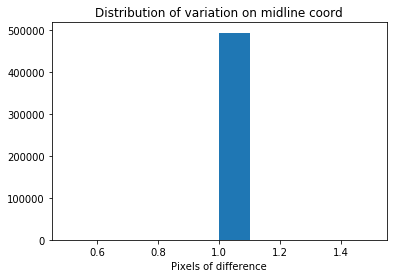

In [49]:
midline_arr = np.array([[[k], v] for k, v in midline_check.items()])

dif_midline = [max(i[1])- min(i[1]) for i in midline_arr if len(i[1]) > 1]
dif_midline = [i for i in dif_midline if i < 10]

plt.hist(dif_midline)
plt.title('Distribution of variation on midline coord')
plt.xlabel("Pixels of difference")
plt.savefig('../results/checking-new-coords/midline-distribution.png')
plt.show()